In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
from sqlalchemy import create_engine

engine = create_engine(
    "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
    "postgres.lab.karpov.courses:6432/startml"
)

In [3]:
post_df = pd.read_sql('SELECT * FROM public.post_text_df', con=engine)

In [4]:
post_df.describe(include='object')

,text,topic
count,7023,7023
unique,6924,7
top,Microsoft gets the blogging bug\n\nSoftware gi...,movie
freq,2,3000


In [5]:
post_df.columns

Index(['post_id', 'text', 'topic'], dtype='object')

In [6]:
post_df.topic.value_counts()

movie            3000
covid            1799
business          510
sport             510
politics          417
tech              401
entertainment     386
Name: topic, dtype: int64

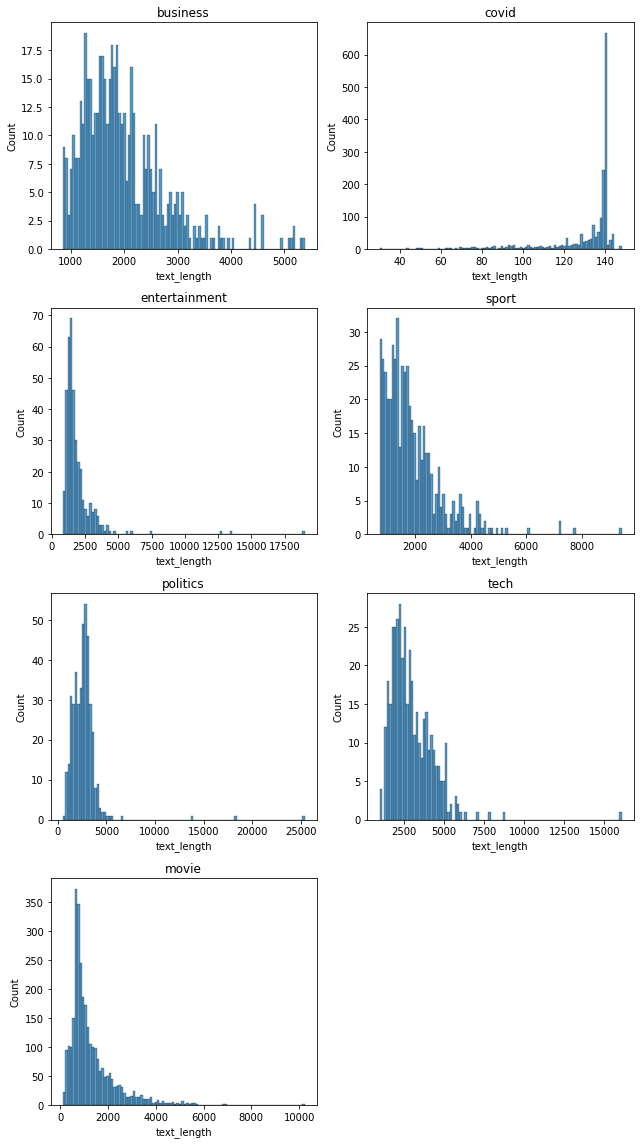

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
fig = plt.figure(figsize=(9, 16))

unique_topics = post_df.topic.unique()

for i, topic in enumerate(unique_topics, 1):
    
    
    plt.subplot(4, 2, i)
    
    length = post_df[post_df['topic']==topic]['text'].map(len)
    
    sns.histplot(data=length, bins=100)
    plt.title(f'{topic}')
    plt.xlabel('text_length')
    
    plt.tight_layout() 

In [8]:
posts_distribution = pd.read_sql("""
SELECT
    post_id,
    SUM(CASE WHEN action = 'view' THEN 1 ELSE 0 END) AS views,
    COUNT(DISTINCT CASE WHEN action = 'view' THEN user_id END) AS view_reach
FROM public.feed_data
GROUP BY 1
ORDER BY 1
""", con=engine)
posts_distribution

,post_id,views,view_reach
0,1,8508,8198
1,2,7495,7306
2,3,8412,8159
3,4,8158,7902
4,5,8583,8304
...,...,...,...
6826,7315,16940,15946
6827,7316,6572,6430
6828,7317,6803,6636
6829,7318,6785,6630


In [9]:
posts_distribution.describe()

,post_id,views,view_reach
count,6831.000000,6831.000000,6831.000000
mean,3719.757869,10055.109794,9589.989606
std,2106.217008,5168.012109,4666.445312
min,1.000000,6423.000000,6289.000000
25%,1863.000000,6712.000000,6564.000000
50%,3758.000000,6873.000000,6714.000000
75%,5541.500000,12249.500000,11395.000000
max,7319.000000,22673.000000,20892.000000


In [10]:
post_df = post_df.merge(posts_distribution, how='left', on='post_id')

In [11]:
post_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7023 entries, 0 to 7022
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   post_id     7023 non-null   int64  
 1   text        7023 non-null   object 
 2   topic       7023 non-null   object 
 3   views       6831 non-null   float64
 4   view_reach  6831 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 329.2+ KB


In [12]:
post_df = post_df.fillna(0)

In [ ]:
%pip install spacy==3.5.0

In [ ]:
%pip install en-core-web-sm@https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.5.0/en_core_web_sm-3.5.0-py3-none-any.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 42.8 MB/s eta 0:00:0000:0100:01


In [15]:
import spacy
import pandas as pd
from tqdm import tqdm 

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def lemmatize_text(text):
    doc = nlp(text)
    lemmas = [
        token.lemma_.lower() if not token.text.isdigit() else token.text
        for token in doc
        if not token.is_space and not token.is_punct
    ]
    return lemmas

def lemmatize_column(df, column_name, new_column="lemmas"):
    tqdm.pandas(desc="Lemmatization")
    df[new_column] = df[column_name].progress_apply(lemmatize_text)
    return df

In [16]:
post_df = lemmatize_column(post_df, "text")

Lemmatization: 100%|██████████| 7023/7023 [02:29<00:00, 47.12it/s] 


In [17]:
post_df["lemmas"].head()

0    [uk, economy, face, major, risk, the, uk, manu...
1    [aid, and, climate, top, davos, agenda, climat...
2    [asian, quake, hit, european, share, share, in...
3    [india, power, share, jump, on, debut, share, ...
4    [lacroix, label, buy, by, us, firm, luxury, go...
Name: lemmas, dtype: object

In [18]:
type(post_df["lemmas"][0])

list

In [19]:
post_df["lemmas"] = post_df["lemmas"].apply(" ".join)

In [20]:
type(post_df["lemmas"][0])

str

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
# lowercase=True, tokenizer=str.split
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(post_df["lemmas"])

In [22]:
tfidf_df = pd.DataFrame(
    data=tfidf_matrix.toarray(),
    index=post_df.post_id,
    columns=tfidf.get_feature_names_out()
)
tfidf_df.head()

,00,000,0001,000bn,000s,000th,001,001and,001st,002,...,𝓫𝓮,𝓫𝓮𝓽𝓽𝓮𝓻,𝓬𝓸𝓾𝓻𝓽𝓼,𝓱𝓮𝓪𝓻𝓲𝓷𝓰,𝓶𝓪𝔂,𝓹𝓱𝔂𝓼𝓲𝓬𝓪𝓵,𝓼𝓸𝓸𝓷𝓮𝓻,𝓼𝓾𝓫𝓸𝓻𝓭𝓲𝓷𝓪𝓽𝓮,𝓽𝓱𝓮,𝓽𝓸
post_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.115644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.045768,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
post_df['TotalTfIdf'] = post_df.sum(axis=1).reset_index()[0]
post_df['MaxTfIdf'] = post_df.max(axis=1).reset_index()[0]
post_df['MeanTfIdf'] = post_df.mean(axis=1).reset_index()[0]

post_df.head()

,post_id,text,topic,views,view_reach,lemmas,TotalTfIdf,MaxTfIdf,MeanTfIdf
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8508.0,8198.0,uk economy face major risk the uk manufacturin...,16707.0,16707.0,10024.2
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,7495.0,7306.0,aid and climate top davos agenda climate chang...,14803.0,14803.0,8881.8
2,3,Asian quake hits European shares\n\nShares in ...,business,8412.0,8159.0,asian quake hit european share share in europe...,16574.0,16574.0,9944.4
3,4,India power shares jump on debut\n\nShares in ...,business,8158.0,7902.0,india power share jump on debut share in india...,16064.0,16064.0,9638.4
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,8583.0,8304.0,lacroix label buy by us firm luxury good group...,16892.0,16892.0,10135.2


In [24]:
from sklearn.decomposition import PCA

In [25]:
pca = PCA(n_components=20)
pca_decomp = pca.fit_transform(tfidf_matrix.toarray())

In [26]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=42).fit(pca_decomp)

post_df['TextCluster'] = kmeans.labels_

dists_columns = ['DistanceTo1thCluster',
                 'DistanceTo2thCluster',
                 'DistanceTo3thCluster',
                 'DistanceTo4thCluster',
                 'DistanceTo5thCluster',
                 'DistanceTo6thCluster',
                 'DistanceTo7thCluster',
                 'DistanceTo8thCluster',
                 'DistanceTo9thCluster',
                 'DistanceTo10thCluster',
                 'DistanceTo11thCluster',
                 'DistanceTo12thCluster',
                 'DistanceTo13thCluster',
                 'DistanceTo14thCluster',
                 'DistanceTo15thCluster']

dists_df = pd.DataFrame(
    data=kmeans.transform(pca_decomp),
    columns=dists_columns
)

dists_df.head()

,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,0.524348,0.418481,0.544030,0.136581,0.421559,0.503392,0.456399,0.406657,0.486158,0.441582,0.410256,0.343748,0.450046,0.475399,0.438412
1,0.472383,0.309927,0.497811,0.259299,0.315602,0.415336,0.222588,0.290963,0.401290,0.323024,0.256752,0.199950,0.326149,0.378603,0.353479
2,0.466861,0.326240,0.489840,0.118212,0.368118,0.426340,0.420194,0.339245,0.406688,0.355907,0.327214,0.234535,0.361338,0.406536,0.353821
3,0.342160,0.303066,0.364095,0.192145,0.319533,0.395690,0.380983,0.279148,0.379286,0.385199,0.274392,0.134339,0.341965,0.368483,0.274278
4,0.270546,0.293175,0.303419,0.287785,0.289954,0.374062,0.379334,0.244794,0.353474,0.394926,0.283290,0.140889,0.290718,0.347616,0.213190


In [27]:
post_df = pd.concat((post_df, dists_df), axis=1)

post_df.head()

,post_id,text,topic,views,view_reach,lemmas,TotalTfIdf,MaxTfIdf,MeanTfIdf,TextCluster,...,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8508.0,8198.0,uk economy face major risk the uk manufacturin...,16707.0,16707.0,10024.2,3,...,0.503392,0.456399,0.406657,0.486158,0.441582,0.410256,0.343748,0.450046,0.475399,0.438412
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,7495.0,7306.0,aid and climate top davos agenda climate chang...,14803.0,14803.0,8881.8,11,...,0.415336,0.222588,0.290963,0.401290,0.323024,0.256752,0.199950,0.326149,0.378603,0.353479
2,3,Asian quake hits European shares\n\nShares in ...,business,8412.0,8159.0,asian quake hit european share share in europe...,16574.0,16574.0,9944.4,3,...,0.426340,0.420194,0.339245,0.406688,0.355907,0.327214,0.234535,0.361338,0.406536,0.353821
3,4,India power shares jump on debut\n\nShares in ...,business,8158.0,7902.0,india power share jump on debut share in india...,16064.0,16064.0,9638.4,11,...,0.395690,0.380983,0.279148,0.379286,0.385199,0.274392,0.134339,0.341965,0.368483,0.274278
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,8583.0,8304.0,lacroix label buy by us firm luxury good group...,16892.0,16892.0,10135.2,11,...,0.374062,0.379334,0.244794,0.353474,0.394926,0.283290,0.140889,0.290718,0.347616,0.213190


In [28]:
post_df = post_df.drop(['lemmas'], axis=1)

In [ ]:
# post_df.to_csv("posts_feautures.csv", index=False)

In [21]:
import pandas as pd
post_df = pd.read_csv("posts_feautures.csv")

In [22]:
from config.constants import PROCESSED_DIR
import pickle

pkl_path = PROCESSED_DIR / "post_df.pkl"
with open(pkl_path, 'wb') as f:
    pickle.dump(post_df, f)